In [1]:
from matplotlib.pyplot import axes


def prepare_data(
    dataset,
    num_imgs=10,
    preprocess_sensory=True,
    noise_level="medium",
):
    import torch
    import random

    data = dataset.data
    # print(num_imgs)
    # print(data.shape)
    data = data.reshape(data.shape[0], -1)
    # print(data.shape)
    data = torch.tensor(data[:num_imgs]).float().to("cpu")
    # print(data.shape)

    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        data = (data - data.mean()) / data.std()
        # print(mnist_data[0])

    # noissing the data
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise
    # TODO: DO WE PREPROCESS NOISY IMAGES?
    # if preprocess_sensory:
    #     noisy_mnist = (noisy_mnist - noisy_mnist.mean()) / noisy_mnist.std()

    return data, noisy_data

In [2]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
from matrix_initializers import SparseMatrixByScalingInitializer
from vectorhash_functions import solve_mean, spacefillingcurve
import math


def test_memory_capacity(
    data,
    noisy_data,
    shapes=[(3, 3, 5), (4, 4, 7)],
    N_h=1000,
    initalization_method="by_scaling",
    percent_nonzero_relu=0.01,
    var=1.0,
    sparse_initialization=0.1,
    T=0.01,
):

    GS = GridScaffold(
        shapes=shapes,
        N_h=N_h,
        input_size=data.shape[1],
        device="cpu",
        sparse_matrix_initializer=(
            SparseMatrixByScalingInitializer(
                mean=solve_mean(p=percent_nonzero_relu, var=(len(shapes) * var))
                / len(shapes),
                # TODO: this calculates the mean of the sum of distributions, but we want the mean of just one of the distributions so we should divide my M right?
                scale=math.sqrt(var),
            )
            if initalization_method == "by_scaling"
            else SparseMatrixBySparsityInitializer(sparsity=sparse_initialization)
        ),
        relu_theta=(
            0.0
            if initalization_method == "by_scaling"
            else solve_mean(
                p=percent_nonzero_relu, var=len(shapes) * (1 - sparse_initialization)
            )
        ),
        T=T,
        continualupdate=True,
        ratshift=False,
        initialize_W_gh_with_zeroes=True,
    )

    # learn over all images
    v = spacefillingcurve(shapes)

    GS.learn_path(observations=data, velocities=v[: len(data)])
    print(len(v[: len(data)]))
    recalled_imgs = GS.recall(noisy_data)

    similarity = torch.nn.functional.cosine_similarity(data, recalled_imgs)
    return similarity

[1, 3, 8, 15, 25, 37, 56, 67, 74, 82, 111, 148, 222, 739]
module shapes:  [(5, 5), (9, 9), (11, 11)]
N_g     :  227
N_patts :  245025
N_h     :  1000
1
G not denoised
avg nonzero H: 10.0
avg nonzero H_denoised: 10.0
Unique Gs: 1
tensor(1.0000)
module shapes:  [(5, 5), (9, 9), (11, 11)]
N_g     :  227
N_patts :  245025
N_h     :  1000
3
G not denoised
avg nonzero H: 25.0
avg nonzero H_denoised: 8.666666984558105
Unique Gs: 3
tensor(0.9998)
module shapes:  [(5, 5), (9, 9), (11, 11)]
N_g     :  227
N_patts :  245025
N_h     :  1000
8
G not denoised
avg nonzero H: 47.125
avg nonzero H_denoised: 9.875
Unique Gs: 8
tensor(0.9577)
module shapes:  [(5, 5), (9, 9), (11, 11)]
N_g     :  227
N_patts :  245025
N_h     :  1000
15
G not denoised
avg nonzero H: 69.66666412353516
avg nonzero H_denoised: 8.533333778381348
Unique Gs: 14
tensor(0.8815)
module shapes:  [(5, 5), (9, 9), (11, 11)]
N_g     :  227
N_patts :  245025
N_h     :  1000
25
G not denoised
avg nonzero H: 117.27999877929688
avg nonzer

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (14,) + inhomogeneous part.

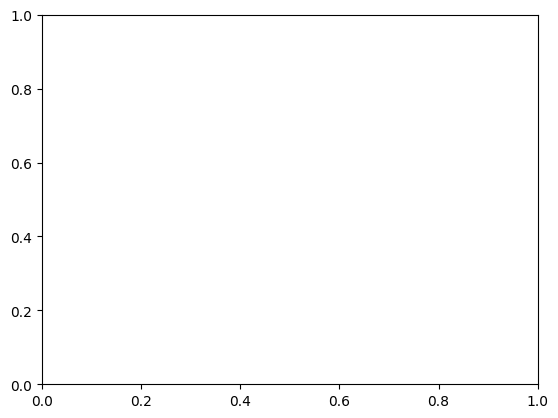

In [3]:
# Memory Capacity Tests
import torchvision
from torchvision import transforms
import torch

shapes = [(5, 5), (9, 9), (11, 11)]
N_h = 1000

N_g = 0
for shape in shapes:
    l = torch.prod(torch.tensor(shape)).item()
    N_g += l
# print("N_g", N_g)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
# dataset = torchvision.datasets.MNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

dataset = torchvision.datasets.CIFAR100(
    root="data", train=True, download=True, transform=transform
)

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST

percents = [
    0.01,
    0.03,
    0.1,
    0.2,
    0.33,
    0.5,
    0.75,
    0.9,
    1.0,
    1.1,
    1.5,
    2.0,
    3.0,
    10.0,
]

num_images = [theoretical_capacity * p for p in percents]
num_images = [math.ceil(n) for n in num_images]
print(num_images)

preprocess_sensory = True
noise_level = "medium"

# TODO: Need a hyperparam N_p for dimension of the projection from grid cells to place cells
similarities = []
for num_imgs in num_images:
    print("==========================================")
    data, noisy_data = prepare_data(
        dataset,
        num_imgs=num_imgs,
        preprocess_sensory=preprocess_sensory,
        noise_level=noise_level,
    )
    similarity = test_memory_capacity(
        data,
        noisy_data,
        shapes=shapes,
        N_h=N_h,
        initalization_method="by_scaling",
        percent_nonzero_relu=10 / N_h,
        var=1.0,
        sparse_initialization=0.0,
    )
    print(torch.mean(similarity))
    similarities.append(similarity)

import matplotlib.pyplot as plt

plt.plot(percents * 100, similarities)
plt.xscale("log")
plt.xlabel("Number of Images")
plt.ylabel("Similarity")
plt.title("Memory Capacity")
plt.show()